# Unpaired image-to-image translation

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
from src.utils import get_files

## Import frames

In [3]:
base_dir = '/Users/jcboyd/Data/IncuCyte/ZG-MS-CD8T_cytotoxicity/'
experiment = 'raji_target'

train_files, val_files, test_files = get_files(base_dir, experiment)
all_files = train_files + val_files

to_export = []

for i in range(0, len(all_files), 110):  # jump over fields
    for j in range(0, 48, 12):  # jump one day at a time
        to_export.append(all_files[i + j])

pc_img = []

for file_name in to_export:
    pc_img.append(imread(os.path.join(base_dir, 'phase_contrast', file_name)))

No. train images: 1540
No. val images: 110
No. test images: 110


/Users/jcboyd/anaconda3/lib/python3.7/site-packages/skimage/external/tifffile/tifffile.py:2616: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)


In [4]:
def preprocess_pc(img):

    return img / 255.

pc_img = [preprocess_pc(img) for img in pc_img]

## Extract crops

In [5]:
crop_size = 128

crops = []

for pc in pc_img:
    for y in range(0, pc.shape[0] - crop_size, crop_size):
        for x in range(0, pc.shape[1] - crop_size, crop_size):
            pc_crop = pc[y:y+crop_size, x:x+crop_size]
            crops.append(pc_crop)

crops = np.stack(crops)
x_train, x_test = crops[:1120], crops[1120:]

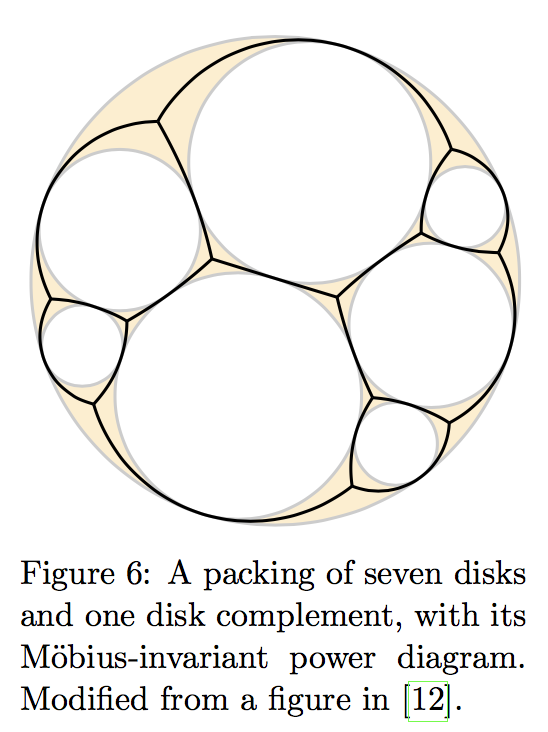

In [6]:
from IPython.display import Image
Image('./voronoi.png')

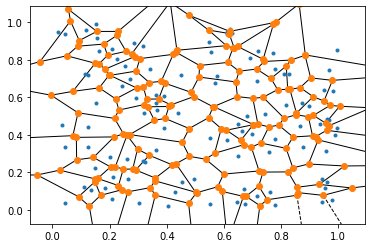

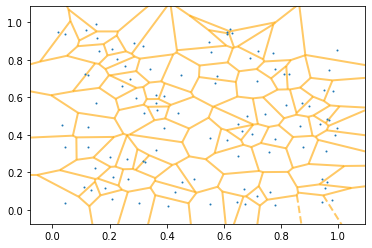

In [7]:
import matplotlib.pyplot as plt
points = np.random.rand(100, 2) #random

from scipy.spatial import Voronoi, voronoi_plot_2d

vor = Voronoi(points)

fig = voronoi_plot_2d(vor)

fig = voronoi_plot_2d(vor, show_vertices=False, line_colors='orange',
                      line_width=2, line_alpha=0.6, point_size=2)
plt.show()

We inject some simple rules about what content ought appear. In supplying a background, contour, and interior masks, of approximate size and shape, we lower the optimal transport cost to be learned by the CycleGAN generators.

In [8]:
from src.style_transfer import draw_content

import numpy as np
from skimage.morphology import disk, diamond, erosion, dilation

import torch
import torch.nn as nn
from torch import optim
from torchvision.models import vgg19
import torchvision.transforms as transforms

mu_0, sigma_0, min_0, max_0 = 4.84, 2 * 0.94, 4, 10
mu_1, sigma_1, min_1, max_1 = 3.46, 0.58, 3, 7

p_dead = 0.2
delta = 2  # compensate for cell perimiter lost during segmentation

def draw_content(style_img, nb_cells, selem='disk', mode='no-overlap'):

    canvas = np.zeros((128, 128, 2))
    instance_mask = np.zeros((128, 128))
    bboxes = []

    clearance_map = np.zeros((128, 128))

    selem = 'disk'
    mode = 'no-overlap'

    for i in range(nb_cells):

        mask_img = np.zeros((128, 128))

        cell_type = 'raji' if np.random.rand() > p_dead else 'dead'

        # Choose cell radius from bimodal distribution
        if cell_type == 'raji':
            r = int(np.clip(delta + mu_0 + sigma_0 * np.random.randn(), min_0, max_0))
        else:
            r = int(np.clip(mu_1 + sigma_1 * np.random.randn(), min_1, max_1))

        ys, xs = np.nonzero(1 - clearance_map)

        coords = list(zip(ys, xs))
        idx = np.random.randint(len(coords))
        y, x = coords[idx]

        mask = disk(r) if selem == 'disk' else diamond(r)

        # determine bounding box
        top = np.maximum(y - r, 0)  # N.B. top < bottom
        bottom = np.minimum(y + r + 1, canvas.shape[0])
        left = np.maximum(x - r, 0)
        right = np.minimum(x + r + 1, canvas.shape[1])

        # adjust at borders
        adjust_top = top - (y - r)
        adjust_bottom = 2 * r - ((y + r + 1) - bottom) + 1
        adjust_left = left - (x - r)
        adjust_right = 2 * r - ((x + r + 1) - right) + 1

        mask_img[top:bottom, left:right] = mask[adjust_top:adjust_bottom,
                                                adjust_left:adjust_right]

        instance_mask[mask_img > 0] = (i + 1) * mask_img[mask_img > 0]

        # mark clearance
        dilated_mask_img = dilation(mask_img, disk(3))
        clearance_map[dilated_mask_img > 0] = dilated_mask_img[dilated_mask_img > 0]

        # insert mask according to mode
        if mode == 'no-overlap':

            if cell_type == 'raji':
                canvas[mask_img > 0, 0] = mask_img[mask_img > 0]
                eroded_mask = erosion(mask_img, disk(1))
                canvas[..., 0] -= eroded_mask
            else:
                canvas[mask_img > 0, 1] = mask_img[mask_img > 0]
                eroded_mask = erosion(mask_img, disk(1))
                canvas[..., 1] -= eroded_mask

        elif mode == 'overlap':

            eroded_mask = erosion(mask_img, disk(1))
            mask_img -= eroded_mask
            canvas[mask_img > 0] = mask_img[mask_img > 0]

        elif mode == 'mask':

            canvas[mask_img > 0] = mask_img[mask_img > 0]

        bboxes.append([left, top, right, bottom])

    return canvas.astype('float32'), instance_mask.astype('uint8'), bboxes, clearance_map

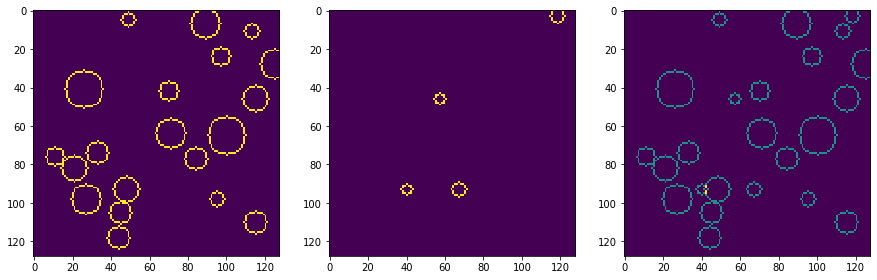

In [9]:
crop = 128

idx = np.random.randint(x_train.shape[0])
style_img = x_train[idx]

nb_cells = np.random.randint(10, 60)

content_img, instance_mask, bboxes, clearance_map = draw_content(np.mean(x_train, axis=0),
                                                                 nb_cells=nb_cells, mode='no-overlap')

fig, axes = plt.subplots(figsize=(15, 5), ncols=3)

axes[0].imshow(content_img[..., 0])
axes[1].imshow(content_img[..., 1])
axes[2].imshow(np.sum(content_img, axis=2))

## Train model

In [10]:
from keras.models import Model
from keras.layers import Input
from keras.optimizers import Adam
from src.models import fnet_cycle, patch_gan_cycle
from src.utils import set_trainable

from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Activation, UpSampling2D
from keras.layers import Conv2DTranspose, concatenate, Concatenate
from keras.layers import Flatten, Reshape, Dense, Dropout, BatchNormalization
from keras.layers import GlobalAveragePooling2D, ZeroPadding2D
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.regularizers import l2
from keras.optimizers import SGD
import keras.backend as K


def fnet_cycle(img_shape, num_filters, output_channels=1):

    def conv2d(layer_input, filters, strides=2, f_size=4):
        """Layers used during downsampling"""
        d = Conv2D(filters, kernel_size=f_size, strides=strides, padding='same')(layer_input)
        d = LeakyReLU(alpha=0.2)(d)
        d = InstanceNormalization()(d)
        return d

    def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
        """Layers used during upsampling"""
        u = UpSampling2D(size=2)(layer_input)
        u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
        if dropout_rate:
            u = Dropout(dropout_rate)(u)
        u = InstanceNormalization()(u)
        u = Concatenate()([u, skip_input])
        return u

    # Image input
    input_img = Input(shape=img_shape)

    in_conv_1 = conv2d(input_img, num_filters, strides=1)
    in_conv_2 = conv2d(in_conv_1, num_filters, strides=1)

    # Downsampling
    d1 = conv2d(in_conv_2, num_filters)
    d2 = conv2d(d1, num_filters * 2)
    d3 = conv2d(d2, num_filters * 4)
    d4 = conv2d(d3, num_filters * 8)
    d5 = conv2d(d4, num_filters * 8)
    d6 = conv2d(d5, num_filters * 8)

    # Upsampling
    u1 = deconv2d(d6, d5, num_filters * 8)
    u2 = deconv2d(u1, d4, num_filters * 8)
    u3 = deconv2d(u2, d3, num_filters * 4)
    u4 = deconv2d(u3, d2, num_filters * 2)
    u5 = deconv2d(u4, d1, num_filters)

    u6 = UpSampling2D(size=2)(u5)

    out_conv_1 = conv2d(u6, num_filters, strides=1)
    out_conv_2 = conv2d(out_conv_1, num_filters, strides=1)

    output_img = Conv2D(output_channels, kernel_size=4, strides=1, padding='same', activation='tanh')(out_conv_2)

    return Model(input_img, output_img)


h, w = x_train.shape[1], x_train.shape[2]
img_shape_A = (h, w, 2)
img_shape_B = (h, w, 1)

disc_patch = (h // 2 ** 4, w // 2 ** 4, 1)

optimizer = Adam(0.0002, 0.5)

# Loss weights
lambda_cycle = 10.0               # Cycle-consistency loss
lambda_id = 0.1 * lambda_cycle    # Identity loss

# Build discriminators
d_A = patch_gan_cycle(img_shape_A)
d_B = patch_gan_cycle(img_shape_B)

d_A.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
d_B.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])

# Build the generators
g_AB = fnet_cycle(img_shape_A, 32, output_channels=2)
g_BA = fnet_cycle(img_shape_B, 32)

# Input images from both domains
img_A = Input(shape=img_shape_A)
img_B = Input(shape=img_shape_B)

# Translate images to the other domain
fake_B = g_AB(img_A)
fake_A = g_BA(img_B)

# reduce A -> B -> A

# Translate images back to original domain
reconstr_A = g_BA(fake_B)
reconstr_B = g_AB(fake_A)

# Identity mapping of images
img_A_id = g_BA(img_A)
img_B_id = g_AB(img_B)

# For the combined model we will only train the generators
set_trainable(d_A, False)
set_trainable(d_B, False)

# Discriminators determines validity of translated images
valid_A = d_A(fake_A)
valid_B = d_B(fake_B)

# Combined model trains generators to fool discriminators
combined = Model(inputs=[img_A, img_B], outputs=[valid_A, valid_B,
                                                 reconstr_A, reconstr_B,
                                                 img_A_id, img_B_id])

combined.compile(loss=['mse', 'mse',
                       'mae', 'mae',
                       'mae', 'mae'],
                 loss_weights=[1, 1,
                               0.1 * lambda_cycle, lambda_cycle,
                               lambda_id, lambda_id],
                 optimizer=optimizer)

ValueError: Depth of input (1) is not a multiple of input depth of filter (2) for 'model_3_1/conv2d_11/convolution' (op: 'Conv2D') with input shapes: [?,128,128,1], [4,4,2,32].

In [11]:
g_BA.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 128, 128, 32) 544         input_4[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_19 (LeakyReLU)      (None, 128, 128, 32) 0           conv2d_27[0][0]                  
__________________________________________________________________________________________________
instance_normalization_22 (Inst (None, 128, 128, 32) 2           leaky_re_lu_19[0][0]             
____________________________________________________________________________________________

In [ ]:
from src.utils import gen_cyclegan, sample_images_cycle

epochs = 200
batch_size = 1

# Adversarial loss ground truths
valid = np.ones((batch_size,) + disc_patch)
fake = np.zeros((batch_size,) + disc_patch)

train_gen = gen_cyclegan(x_train)
steps_per_epoch = x_train.shape[0] // batch_size // 4

for epoch in range(epochs):

    for batch_i in range(steps_per_epoch):

        imgs_A, imgs_B = next(train_gen)

        # Translate images to opposite domain
        fake_B = g_AB.predict(imgs_A)
        fake_A = g_BA.predict(imgs_B)

        # Train the discriminators (original images = real / translated = Fake)

        set_trainable(d_A, True)
        set_trainable(d_B, True)

        dA_loss_real = d_A.train_on_batch(imgs_A, valid)
        dA_loss_fake = d_A.train_on_batch(fake_A, fake)
        dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)

        dB_loss_real = d_B.train_on_batch(imgs_B, valid)
        dB_loss_fake = d_B.train_on_batch(fake_B, fake)
        dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)

        set_trainable(d_A, False)
        set_trainable(d_B, False)

        # Total disciminator loss
        d_loss = 0.5 * np.add(dA_loss, dB_loss)

        # Train the generators
        g_loss = combined.train_on_batch([imgs_A, imgs_B], [valid, valid,
                                                            imgs_A, imgs_B,
                                                            imgs_A, imgs_B])

        # Plot the progress
        print('[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %3d%%] [G loss: %05f, adv: %05f, rec: %05f, id: %05f]' \
              % (epoch, epochs, batch_i, steps_per_epoch, d_loss[0], 100 * d_loss[1], g_loss[0],
                 np.mean(g_loss[1:3]), np.mean(g_loss[3:5]), np.mean(g_loss[5:6])))

    # visualise progress
    sample_images_cycle(g_AB, g_BA, x_test, epoch)

    # save model weights
    g_AB.save_weights('./weights/g_ab_%d.h5' % epoch)
    g_BA.save_weights('./weights/g_ba_%d.h5' % epoch)
    d_A.save_weights('./weights/d_a_%d.h5' % epoch)
    d_B.save_weights('./weights/d_b_%d.h5' % epoch)

## Test model

In [14]:
from src.models import fnet_cycle

g_AB = fnet_cycle(img_shape, 32)
g_AB.load_weights('./weights/g_ab_126.h5')

g_BA = fnet_cycle(img_shape, 32)
g_BA.load_weights('./weights/g_ba_126.h5')

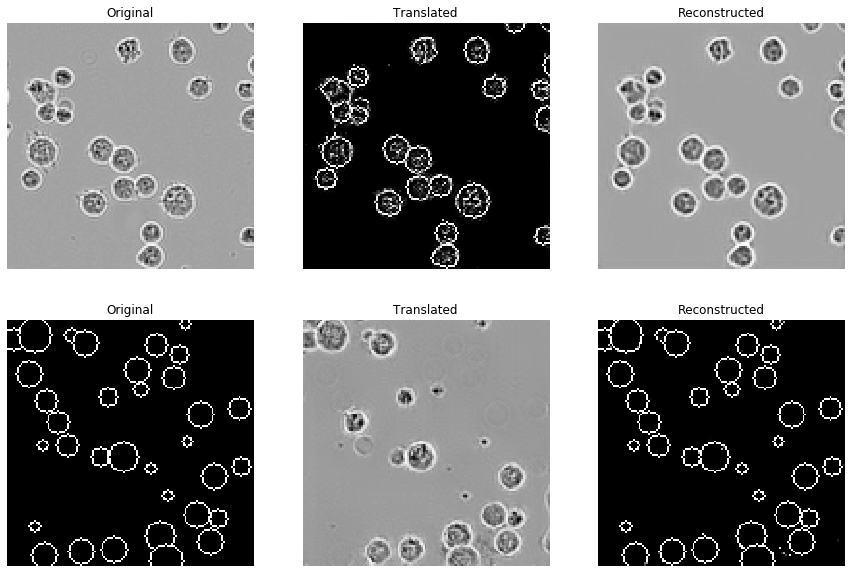

In [22]:
from src.utils import gen_cyclegan
from src.style_transfer import draw_content

gen_test = gen_cyclegan(x_test, batch_size=1)
imgs_A, imgs_B = next(gen_test)

# Translate images to the other domain
fake_B = g_AB.predict(imgs_A)
fake_A = g_BA.predict(imgs_B)

# Translate back to original domain
reconstr_A = g_BA.predict(fake_B)
reconstr_B = g_AB.predict(fake_A)

gen_imgs = np.concatenate([imgs_A, fake_B, reconstr_A, imgs_B, fake_A, reconstr_B])

# Rescale images
gen_imgs = 0.5 * gen_imgs + 0.5

titles = ['Original', 'Translated', 'Reconstructed']
fig, axs = plt.subplots(figsize=(15, 10), nrows=2, ncols=3)

cnt = 0

for i in range(2):

    for j in range(3):

        axs[i,j].imshow(gen_imgs[cnt].squeeze(), cmap='Greys_r')
        axs[i, j].set_title(titles[j])
        axs[i,j].axis('off')
        cnt += 1

At present, one can observe the troubling phenomenon of vanishing cells in the A->B translation (bottom), even if the reconstruction is near-perfect. Simultaneously, the B->A translation is likewise poor, yet the reconstruction is also excellent. Neither of these cases show vanishing cells, however. Recall that neither discriminator is conditional, hence may still be satisfied if the inputs and outputs do not correspond (this ought rather to be enforced by the cycle dependencies).

It therefore seems that the AB generator is benefitting from interior cell textures preserved by the BA generator (top middle), so as to assist it with the reconstruction, in effect, offloading the generative burden. Note that the $L_1$ loss will be much higher for the A->B->A reconstruction than its counterpart (this should be confirmed empirically). However, when faced with the textureless ground truth images (bottom left), the 

One can imagine several ways to address this problem:

1) Reduce the weight on the A->B->A reconstruction

2) Change the mask appearance to increase its relative importance